# Quantum Fourier Transform Benchmark

In [1]:
low = 1
high = 28
samples = 100

In [2]:
import time
import random
import math
import numpy as np

## FFTW ("Classical" DFT)

In [17]:
# See https://blog.hpc.qmul.ac.uk/pyfftw.html

import pyfftw

pyfftw.config.NUM_THREADS = 1
pyfftw.config.PLANNER_EFFORT = 'FFTW_MEASURE'
pyfftw.interfaces.cache.enable()
pyfftw.interfaces.cache.set_keepalive_time(60)
total_time = 0

fftw_results = {}
for n in range(low, high + 1):
    width_results = []
    for i in range(samples):
        io_array = pyfftw.empty_aligned(2**n, dtype=np.complex64)
        io_array[0] = 1.
        start = time.perf_counter()
        pyfftw.interfaces.numpy_fft.fft(io_array, overwrite_input=True, threads = (16 if (n > 19) else 1))
        width_results.append(time.perf_counter() - start)

    fftw_results[n] = sum(width_results) / samples

print(fftw_results)

{1: 1.9686799932969735e-05, 2: 1.650663973123301e-05, 3: 1.7741760166245514e-05, 4: 1.182391009933781e-05, 5: 1.374010018480476e-05, 6: 1.9638710145954974e-05, 7: 3.371329978108406e-05, 8: 1.2575760338222609e-05, 9: 1.309838997258339e-05, 10: 0.00013330450012290383, 11: 5.602954974165186e-05, 12: 0.00038778735004598277, 13: 0.0009808307898492785, 14: 0.0015007998399232747, 15: 0.0030772279301891103, 16: 0.00910858497976733, 17: 0.012260131009898033, 18: 0.02921623162008473, 19: 0.01345128389992169, 20: 0.039938455229857936, 21: 0.04388814600948535, 22: 0.0502960723596334, 23: 0.06500334859010763, 24: 0.10383524256962119, 25: 0.1730342404102703, 26: 0.3369515074403171, 27: 0.6856755644505756, 28: 1.6053181030303676}


## PyQrack

In [4]:
%env QRACK_QUNITMULTI_DEVICES 1
from pyqrack import QrackSimulator, Pauli

def reverse_qrack(sim):
    start = 0
    end = sim.num_qubits() - 1
    while (start < end):
        sim.swap(start, end)
        start += 1
        end -= 1

env: QRACK_QUNITMULTI_DEVICES=1


### |0> initialization

In [5]:
def bench_qrack_0(n):
    sim = QrackSimulator(n)
    # Permutation basis eigenstate initialization before QFT is "trivial" for Qrack.
    start = time.perf_counter()
    qubits = [i for i in range(n)]
    sim.qft(qubits)
    reverse_qrack(sim)
    sim.m_all()

    return time.perf_counter() - start

qrack_0_results = {}
for n in range(low, high + 1):
    width_results = []
        
    # Run the benchmarks
    for i in range(samples):
        width_results.append(bench_qrack_0(n))

    qrack_0_results[n] = sum(width_results) / samples

print(qrack_0_results)

Device #0, Loaded binary from: /home/iamu/.qrack/qrack_ocl_dev_Intel(R)_UHD_Graphics_[0x9bc4].ir
Device #1, Loaded binary from: /home/iamu/.qrack/qrack_ocl_dev_NVIDIA_GeForce_RTX_3080_Laptop_GPU.ir
{1: 7.3966701893368735e-06, 2: 9.692509920569136e-06, 3: 1.1230190139031038e-05, 4: 1.3849469978595152e-05, 5: 1.6473100331495515e-05, 6: 1.875399968412239e-05, 7: 2.0153879740973935e-05, 8: 2.2702149944962002e-05, 9: 2.5591699741198683e-05, 10: 2.843265996489208e-05, 11: 3.070041959290393e-05, 12: 3.410069992241915e-05, 13: 3.6333530515548774e-05, 14: 3.9705839881207794e-05, 15: 4.2608549774740824e-05, 16: 4.629580056644045e-05, 17: 4.9775959996622984e-05, 18: 5.5099059682106597e-05, 19: 5.7166169935953806e-05, 20: 6.288766024226789e-05, 21: 6.512011983431875e-05, 22: 6.964556014281698e-05, 23: 7.270199021149892e-05, 24: 7.763340036035516e-05, 25: 8.223629964049906e-05, 26: 8.60411798930727e-05, 27: 9.065963022294454e-05, 28: 9.441081041586586e-05}


### Random 1-qubit unitary initialization

In [6]:
def bench_qrack(n):
    sim = QrackSimulator(n)
    # Permutation basis eigenstate initialization before QFT is "trivial" for Qrack,
    # so we give it a realistic case instead.
    for i in range(n):
        # Initialize with uniformly random single qubit gates, across full width.
        sim.u(i, random.uniform(0, 4 * math.pi), random.uniform(0, 4 * math.pi), random.uniform(0, 4 * math.pi))
    start = time.perf_counter()
    qubits = [i for i in range(n)]
    sim.qft(qubits)
    reverse_qrack(sim)
    sim.m_all()

    return time.perf_counter() - start

qrack_results = {}
for n in range(low, high + 1):
    width_results = []
        
    # Run the benchmarks
    for i in range(samples):
        width_results.append(bench_qrack(n))

    qrack_results[n] = sum(width_results) / samples

print(qrack_results)

{1: 7.031229615677148e-06, 2: 5.3777329812874084e-05, 3: 0.00014789781002036762, 4: 0.00019707656043465248, 5: 0.00022934950990020298, 6: 0.0003136405803525122, 7: 0.00039728330048092173, 8: 0.0005140463302086573, 9: 0.0006576382601633668, 10: 0.0008864532400184544, 11: 0.001524026129845879, 12: 0.00206082854019769, 13: 0.002459358070627786, 14: 0.002959292470186483, 15: 0.0034420060199045113, 16: 0.003894951569964178, 17: 0.004274053570043179, 18: 0.004914610970372451, 19: 0.005846230519091477, 20: 0.00787496123033634, 21: 0.010905375540460227, 22: 0.01658991922013229, 23: 0.027808948409874575, 24: 0.050011345469756635, 25: 0.09349504326011811, 26: 0.1817608656505763, 27: 0.3587691691407963, 28: 0.7042646102204162}


## Qiskit Aer

In [7]:
from qiskit import QuantumCircuit
from qiskit import execute, Aer
from qiskit.providers.aer import QasmSimulator

def reverse_aer(num_qubits, circ):
    start = 0
    end = num_qubits - 1
    while (start < end):
        circ.swap(start, end)
        start += 1
        end -= 1

# Implementation of the Quantum Fourier Transform
def aer_qft(num_qubits, circ):
    # Quantum Fourier Transform
    for j in range(num_qubits):
        for k in range(j):
            circ.cp(math.pi/float(2**(j-k)), j, k)
        circ.h(j)
    reverse_aer(num_qubits, circ)
    for j in range(num_qubits):
        circ.measure(j, j)

    return circ

sim_backend = QasmSimulator(shots=1, method='statevector_gpu')

def bench_aer(num_qubits):
    circ = QuantumCircuit(num_qubits, num_qubits)
    aer_qft(num_qubits, circ)
    start = time.perf_counter()
    job = execute([circ], sim_backend, timeout=600)
    result = job.result()
    return time.perf_counter() - start

aer_results = {}
for n in range(low, high + 1):
    width_results = []
        
    # Run the benchmarks
    for i in range(samples):
        width_results.append(bench_aer(n))

    aer_results[n] = sum(width_results) / samples

print(aer_results)

{1: 0.0034339191505569034, 2: 0.0036559358398517362, 3: 0.004455032469850267, 4: 0.005387185369982035, 5: 0.0062491973498981675, 6: 0.007255290629691444, 7: 0.008143717690254562, 8: 0.00935081176001404, 9: 0.010203833040504833, 10: 0.011218948750029085, 11: 0.012957129059941508, 12: 0.014015103430574527, 13: 0.015310458150415797, 14: 0.016074535660081893, 15: 0.01840485384047497, 16: 0.019802566089929315, 17: 0.02191450037971663, 18: 0.02383906296985515, 19: 0.028061178279676822, 20: 0.03440034711937187, 21: 0.04436803879063518, 22: 0.06466615396006091, 23: 0.11081594291943475, 24: 0.20559505734003325, 25: 0.3962248424104473, 26: 0.8440370655198786, 27: 1.682919568760044, 28: 3.57916719989953}


## Qulacs

In [8]:
import qulacs

def reverse_qulacs(num_qubits, circ):
    start = 0
    end = num_qubits - 1
    while (start < end):
        circ.add_gate(qulacs.gate.SWAP(start, end))
        start += 1
        end -= 1

def get_rotz(exponent: float) -> np.ndarray:
    return np.diag([1., np.exp(1.j * np.pi * exponent)])

def bench_qulacs(n):
    sim = qulacs.QuantumStateGpu(n)
    circ = qulacs.QuantumCircuit(n)
    start = time.perf_counter()

    for j in range(n):
        for k in range(j):
            mat = get_rotz(math.pi/float(2**(j-k)))
            gate = qulacs.gate.DenseMatrix(k, mat)
            gate.add_control_qubit(j, 1)
            circ.add_gate(gate)
        circ.add_gate(qulacs.gate.H(j))
    reverse_qulacs(n, circ)
    for index in range(n):
        circ.add_gate(qulacs.gate.Measurement(index, index))

    circ.update_quantum_state(sim)

    return time.perf_counter() - start

qulacs_results = {}
for n in range(low, high + 1):
    width_results = []
        
    # Run the benchmarks
    for i in range(samples):
        width_results.append(bench_qulacs(n))

    qulacs_results[n] = sum(width_results) / samples

print(qulacs_results)

{1: 0.00018829108965292106, 2: 0.0004024359498725971, 3: 0.000536848590199952, 4: 0.0006839958602358819, 5: 0.0008009887595835607, 6: 0.0009773494994442444, 7: 0.001119031780253863, 8: 0.0013896646002831403, 9: 0.0016474041099718306, 10: 0.002020620149341994, 11: 0.0024616626595525305, 12: 0.003116011989695835, 13: 0.0035768074704537866, 14: 0.004067158649922931, 15: 0.004557073329779087, 16: 0.007383043639929383, 17: 0.011681167990172981, 18: 0.016371407360129524, 19: 0.024888120060131767, 20: 0.04523050735937431, 21: 0.08614300682063913, 22: 0.1748472543698881, 23: 0.3588234306700178, 24: 0.6864522437405686, 25: 1.3961462681400008, 26: 2.8627979988999868, 27: 5.686958989070263, 28: 13.381054045479614}


## QCGPU

In [9]:
%env PYOPENCL_CTX 1

env: PYOPENCL_CTX=1


In [10]:
import qcgpu

def swap_qcgpu(circ, q1, q2):
    circ.cx(q1, q2)
    circ.cx(q2, q1)
    circ.cx(q1, q2)
    
def reverse_qcgpu(num_qubits, circ):
    start = 0
    end = num_qubits - 1
    while (start < end):
        swap_qcgpu(circ, start, end)
        start += 1
        end -= 1

def bench_qcgpu(num_qubits):
    state = qcgpu.State(num_qubits)
    start = time.perf_counter()
 
    for j in range(num_qubits):
        for k in range(j):
            state.cu1(j, k, math.pi/float(2**(j-k)))
        state.h(j)
    reverse_qcgpu(num_qubits, state)
    state.measure()

    state.backend.queue.finish()
    return time.perf_counter() - start

qcgpu_results = {}
for n in range(low, high + 1):
    width_results = []
         
    # Run the benchmarks
    for i in range(samples):
        width_results.append(bench_qcgpu(n))

    qcgpu_results[n] = sum(width_results) / samples

print(qcgpu_results)

{1: 0.0004128603497520089, 2: 0.0012111598800402135, 3: 0.0016888885403022868, 4: 0.0028500678700220305, 5: 0.0037946517697128, 6: 0.005186533270752989, 7: 0.0065186467904277375, 8: 0.008380027519669965, 9: 0.010096780290114111, 10: 0.01240795965990401, 11: 0.01451521297058207, 12: 0.017236910680294384, 13: 0.019820277679900754, 14: 0.023113182119850535, 15: 0.02620190907000506, 16: 0.03012434160998964, 17: 0.03388507063980797, 18: 0.03923488832973817, 19: 0.045506211019528564, 20: 0.05749774061012431, 21: 0.07240673770997091, 22: 0.09817031804988802, 23: 0.16192053794999084, 24: 0.3354033457201149, 25: 0.6954832251102926, 26: 1.4431001378101065, 27: 2.989618058390188, 28: 6.518496144210003}


## Results

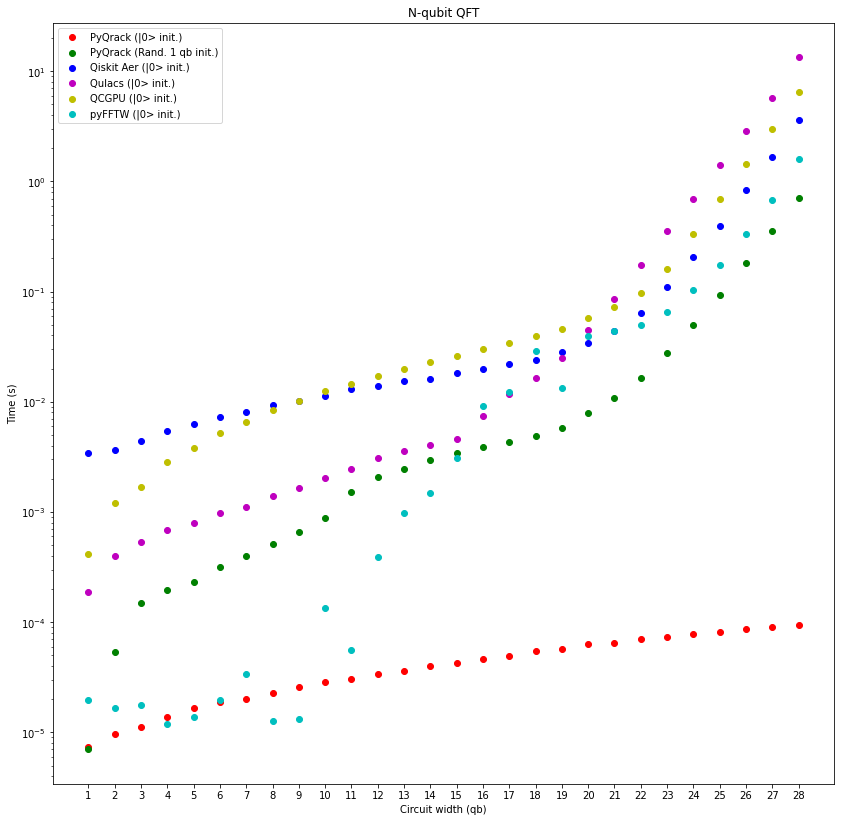

In [19]:
import matplotlib.pyplot as plt

fig = plt.gcf()
fig.set_size_inches(14, 14)

colors = list("cymbgr")

x = qrack_0_results.keys()
y = qrack_0_results.values()
plt.scatter(x,y,color=colors.pop())

x = qrack_results.keys()
y = qrack_results.values()
plt.scatter(x,y,color=colors.pop())

x = aer_results.keys()
y = aer_results.values()
plt.scatter(x,y,color=colors.pop())

x = qulacs_results.keys()
y = qulacs_results.values()
plt.scatter(x,y,color=colors.pop())

x = qcgpu_results.keys()
y = qcgpu_results.values()
plt.scatter(x,y,color=colors.pop())

x = fftw_results.keys()
y = fftw_results.values()
plt.scatter(x,y,color=colors.pop())

plt.title("N-qubit QFT")
plt.xlabel("Circuit width (qb)")
plt.ylabel("Time (s)")
plt.legend(["PyQrack (|0> init.)", "PyQrack (Rand. 1 qb init.)", "Qiskit Aer (|0> init.)", "Qulacs (|0> init.)", "QCGPU (|0> init.)", "pyFFTW (|0> init.)"])
plt.yscale("log")
plt.xticks(np.arange(low, high + 1, step=1))

plt.show()

fig.savefig('qft_chart.png', dpi=100)

In [12]:
import platform

print(platform.machine())
print(platform.version())
print(platform.platform())
print(platform.uname())
print(platform.system())
print(platform.processor())

x86_64
#33~22.04.1-Ubuntu SMP PREEMPT_DYNAMIC Mon Jan 30 17:03:34 UTC 2
Linux-5.19.0-32-generic-x86_64-with-glibc2.35
uname_result(system='Linux', node='sekhmet', release='5.19.0-32-generic', version='#33~22.04.1-Ubuntu SMP PREEMPT_DYNAMIC Mon Jan 30 17:03:34 UTC 2', machine='x86_64')
Linux
x86_64


In [13]:
import subprocess

line_as_bytes = subprocess.check_output("nvidia-smi -L", shell=True)
line = line_as_bytes.decode("ascii")
_, line = line.split(":", 1)
line, _ = line.split("(")
print(line.strip())

NVIDIA GeForce RTX 3080 Laptop GPU


In [14]:
import cpuinfo
cpuinfo.get_cpu_info()['brand_raw']

'Intel(R) Core(TM) i9-10980HK CPU @ 2.40GHz'